In [1]:
import pickle
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

In [2]:
train_snr = 0
test_snr_list = range(0, 25, 5)
print(list(test_snr_list))

[0, 5, 10, 15, 20]


In [3]:
metric_list = ["PSNR", "MS_SSIM", "FID", "LPIPS_VGG"]
metric_names = ["Peak Signal to Noise Ratio (dB)", "Multi Scale SSIM", "FID Score", "LPIPS Score (AlexNet)", "LPIPS Score (VGG)", "LPIPS Score (SqeezeNet)"]

In [4]:
denoised_metrics = pd.DataFrame(columns=metric_list)
denoised_metrics["SNR"] = test_snr_list
denoised_metrics = denoised_metrics[["SNR", *metric_list]]

noisy_metrics = pd.DataFrame(columns=metric_list)
noisy_metrics["SNR"] = test_snr_list
noisy_metrics = noisy_metrics[["SNR", *metric_list]]

jscc_metrics = pd.DataFrame(columns=metric_list)
jscc_metrics["SNR"] = test_snr_list
jscc_metrics = jscc_metrics[["SNR", *metric_list]]

In [5]:
main_dir = "/nfs/turbo/coe-hunseok/ashri/lsun_data/loggings/jscc_models_updated/"
logdir = glob.glob(os.path.join(main_dir, f"snr_{train_snr}", "*"))[0]
logdir

'/nfs/turbo/coe-hunseok/ashri/lsun_data/loggings/jscc_models_updated/snr_0/2023-07-07T01-18-01_jscc_64x64x3'

In [6]:
for metric in metric_list:

    denoised_metric_list = []
    noisy_metric_list = []
    jscc_metric_list = []
    
    for test_snr in test_snr_list:

        denoised_filepath = f"/nfs/turbo/coe-hunseok/ashri/lsun_data/testing_results/bedrooms/ldm_scores_{test_snr}_dict.pkl"
        noisy_filepath = f"/nfs/turbo/coe-hunseok/ashri/lsun_data/testing_results/bedrooms/noisy_latent_scores_{test_snr}_dict.pkl"
        jscc_filepath = os.path.join(logdir, f"train_{train_snr}_test_{test_snr}_metrics.pkl")
        
        denoised_snr_metric = pickle.load(open(denoised_filepath, "rb"))
        noisy_snr_metric = pickle.load(open(noisy_filepath, "rb"))
        jscc_metric = pickle.load(open(jscc_filepath, "rb"))

        denoised_metric_list.append(denoised_snr_metric[metric])
        noisy_metric_list.append(noisy_snr_metric[metric])
        jscc_metric_list.append(jscc_metric[metric])
        
    denoised_metrics[metric] = denoised_metric_list
    noisy_metrics[metric] = noisy_metric_list
    jscc_metrics[metric] = jscc_metric_list

In [7]:
jscc_metrics

,SNR,PSNR,MS_SSIM,FID,LPIPS_VGG
0,0,24.665959,0.890918,224.626003,0.367988
1,5,26.424712,0.918570,193.578712,0.330627
2,10,26.895659,0.922405,200.786826,0.329388
3,15,27.013155,0.923016,200.850763,0.329791
4,20,27.036135,0.923376,201.820206,0.330106


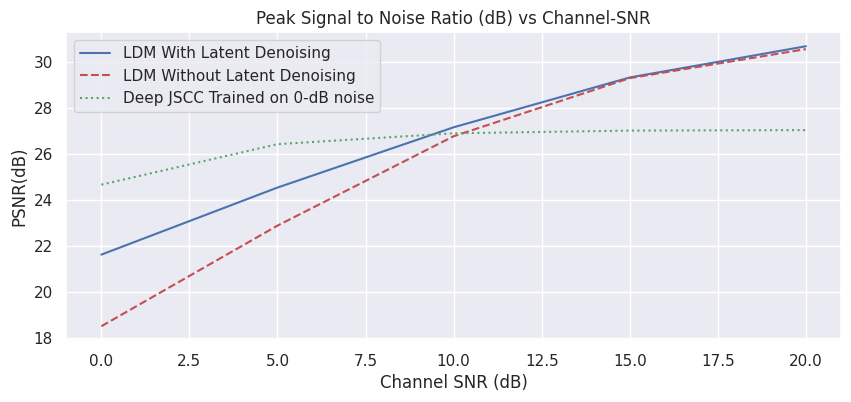

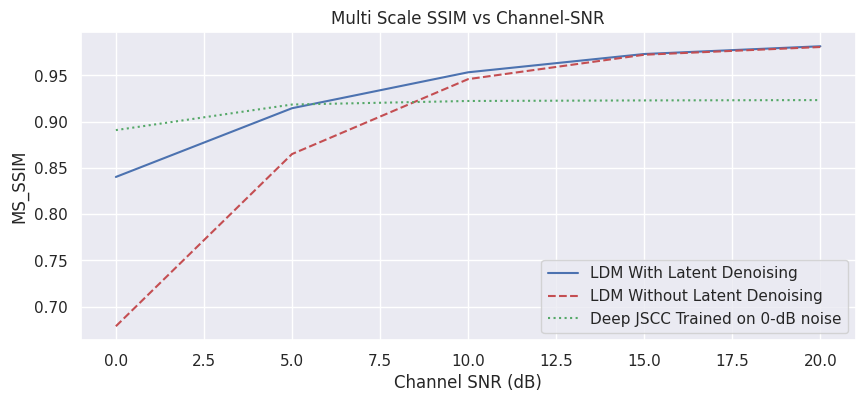

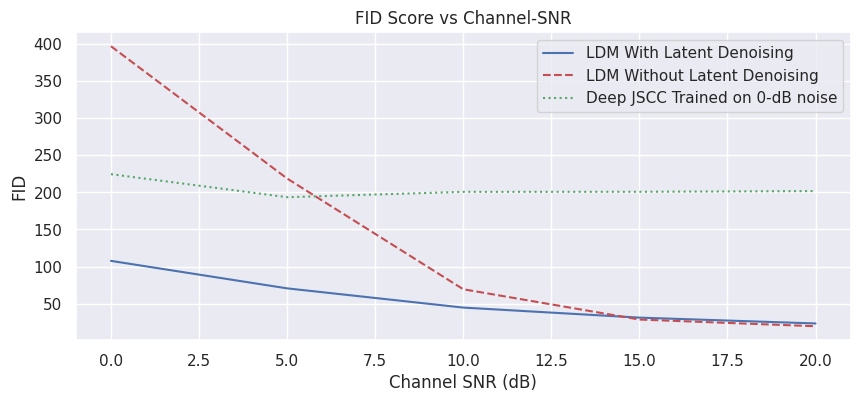

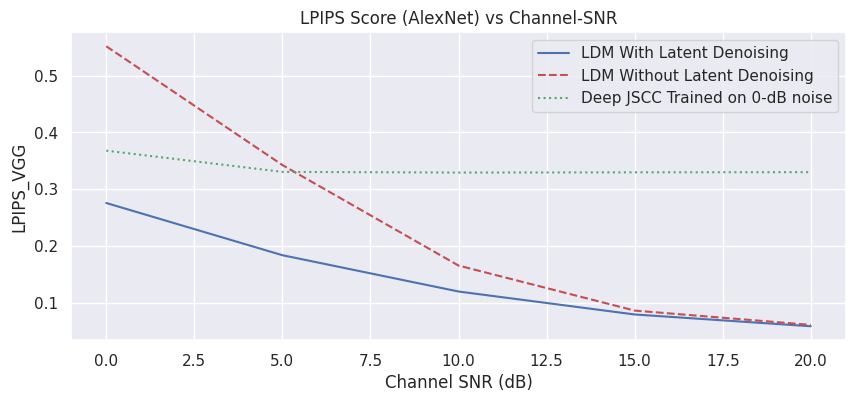

In [8]:
for metric, name in zip(metric_list, metric_names):

    metric_short = (metric + "(dB)") if metric=="PSNR" else metric
    figname = os.path.join(logdir,f"jscc_plot_{metric}_train_{train_snr}.png")
    plt.figure(figsize=(10, 4))
    plt.plot(test_snr_list, denoised_metrics[metric], color = 'b', label = "LDM With Latent Denoising")
    plt.plot(test_snr_list, noisy_metrics[metric], linestyle = "dashed", color='r', label = "LDM Without Latent Denoising")
    plt.plot(test_snr_list, jscc_metrics[metric], linestyle = "dotted", color = 'g', label = f"Deep JSCC Trained on {train_snr}-dB noise")

    plt.title(f"{name} vs Channel-SNR")
    plt.xlabel("Channel SNR (dB)")
    plt.ylabel(f"{metric_short}")
    plt.legend()
    plt.savefig(figname)
    plt.show()
    

In [9]:
jscc_metrics.to_csv(os.path.join(logdir, f"jscc_train_{train_snr}.csv"))